# Attention mechanism

In [3]:
# Standard libraries
import os
import sys
import math

# PyTorch, TorchVision, Lightning
import torch
import torch.nn as nn
import torch.nn.functional as F

## Scaled Dot-Product Attention

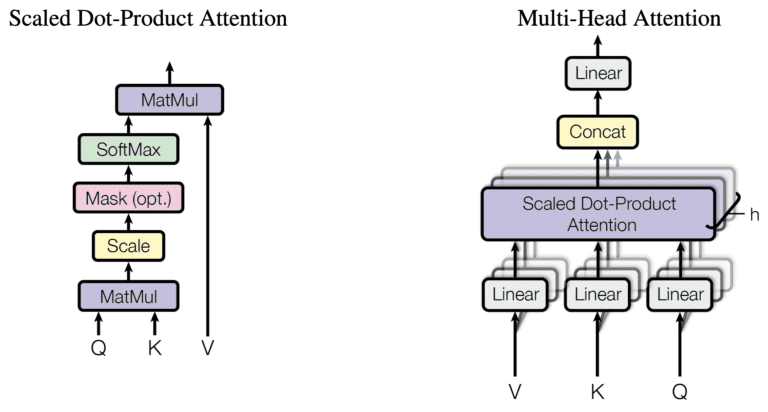

In [29]:
# Input: Q, K, V
# Q = (batch_size, seq_len, d_model)
# K = (batch_size, seq_len, d_model)
# V = (batch_size, seq_len, d_model)

class DotProductAttention(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, Q, K, V, mask=None, dropout=0.1):
        self.dropout = nn.Dropout(p=dropout) # dropout layer which is used to drop some attention scores
        # attention scores (batch_size, seq_len, seq_len)
        d_k = Q.shape[-1]
        # d_k and is the dimension of the key and query vectors. The scaling factor is sqrt(d_k) and is used to prevent the dot products from growing too large in magnitude.
        # The dot products grow large in magnitude because of the dot product of large vectors.
        scores = torch.matmul(Q, K.transpose(-1, -2)) / math.sqrt(d_k)
        
        # Optional: masking 
        if mask is not None:
            # (batch_size, seq_len, seq_len)
            scores = scores.masked_fill(mask == 0, -1e9)
        
        # (batch_size, seq_len, seq_len)
        attention = F.softmax(scores, dim=-1)
        
        # Optional: dropout
        attention = self.dropout(attention)
        
        # (batch_size, seq_len, d_model)
        Z = torch.matmul(attention, V)
        
        return torch.matmul(attention, V), attention

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.1):
        super().__init__()
        assert d_model % n_heads == 0 # d_model must be divisible by n_heads
        
        self.d_model = d_model # size of the embedding vector
        self.n_heads = n_heads # number of heads
        self.d_k = d_model // n_heads # size of the key and query vectors
        
        self.W_Q = nn.Linear(d_model, d_model) # linear layer for Q
        self.W_K = nn.Linear(d_model, d_model) # linear layer for K
        self.W_V = nn.Linear(d_model, d_model) # linear layer for V
        self.W_O = nn.Linear(d_model, d_model) # linear layer for output
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, Q, K, V, mask=None):
        batch_size = Q.shape[0]
        
        # (batch_size, seq_len, d_model)
        Q = self.W_Q(Q)
        K = self.W_K(K)
        V = self.W_V(V)
        
        # split into n_heads and transpose to get (batch_size, n_heads, seq_len, d_k)
        # n_heads is the number of heads and can be seen as a mini batch size for the attention
        Q = Q.view(batch_size, -1, self.n_heads, self.d_k)
        Q = Q.transpose(1, 2)
        
        K = K.view(batch_size, -1, self.n_heads, self.d_k)
        K = K.transpose(1, 2)
        
        V = V.view(batch_size, -1, self.n_heads, self.d_k)
        V = V.transpose(1, 2)
        
        # (batch_size, n_heads, seq_len, d_k)
        Z, attention = DotProductAttention()(Q, K, V, mask, self.dropout.p)
        
        # (batch_size, seq_len, n_heads, d_k)
        Z = Z.transpose(1, 2)
        
        # concatenate all heads
        # (batch_size, seq_len, d_model)
        Z = Z.reshape(batch_size, -1, self.d_model)
        
        # output linear layer
        # (batch_size, seq_len, d_model)
        Z = self.W_O(Z)
        
        # optional: dropout
        Z = self.dropout(Z)
        
        return Z   
    

## Testing the Attention Layer


In [33]:
input_sequence_length = 10
batch_size = 2
d_model = 12

# Create a random input tensor
x = torch.rand(batch_size, input_sequence_length, d_model)
MultiHeadAttention(d_model, n_heads=2)(x, x, x)

tensor([[[ 0.2023,  0.0172,  0.2329, -0.3875, -0.0950, -0.0000,  0.3111,
          -0.0873, -0.0058,  0.2972,  0.1849, -0.5546],
         [ 0.1708, -0.0495,  0.2469, -0.3995, -0.0000, -0.1696,  0.2863,
          -0.0973, -0.0000,  0.2834,  0.1521, -0.5678],
         [ 0.0389, -0.0705,  0.0000, -0.3435, -0.1661, -0.2295,  0.2423,
          -0.0000, -0.0717,  0.2001,  0.0813, -0.4150],
         [ 0.1705, -0.0733,  0.2405, -0.4204, -0.1460, -0.1765,  0.3029,
          -0.1172, -0.0739,  0.2537,  0.1315, -0.5525],
         [ 0.1145, -0.0624,  0.2192, -0.3941, -0.1474, -0.1997,  0.2830,
          -0.0839, -0.0744,  0.2332,  0.1158, -0.5033],
         [ 0.1386, -0.0275,  0.2231, -0.3818, -0.1190, -0.1825,  0.2860,
          -0.0735, -0.0424,  0.0000,  0.1512, -0.5336],
         [ 0.0000, -0.0746,  0.2412, -0.4193, -0.1475, -0.1762,  0.0000,
          -0.1150, -0.0000,  0.2546,  0.1304, -0.5517],
         [ 0.1323, -0.0442,  0.2171, -0.3795, -0.1193, -0.1847,  0.2815,
          -0.0000, -0.04